In [1]:
import torch
import pytorch_lightning as pl

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.cuda.set_device(device)

from hydra.utils import instantiate
from hydra.experimental import initialize, compose

import numpy as np
import time 
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(184)
np.random.seed(143)

print(torch.__version__)
print(device)

1.8.1+cu102
cuda:0


In [2]:
from bliss import sleep
from bliss.datasets import simulated 


In [3]:
import sys
sys.path.append('./../starnet_utils/')
import m2_data
import plotting
import starnet_metrics
import utils

In [4]:
%matplotlib inline

# Load configs and starnet model

In [5]:
with initialize(config_path='./scripts/'):
    cfg = compose("one_source_one_hot_tile")

print('config: ')
print(cfg)

config: 
{'mode': 'train', 'gpus': 1, 'paths': {'root': None, 'output': '${paths.root}/output', 'sdss': '${paths.root}/data/sdss', 'data': '${paths.root}/data'}, 'datasets': {'simulated_m2': {'_target_': 'bliss.datasets.simulated.SimulatedDataset', 'prior': '${models.prior}', 'decoder': '${models.decoder}', 'background': [686.0], 'n_batches': 10, 'batch_size': 20, 'generate_device': 'cuda:0', 'testing_file': None}}, 'models': {'decoder': {'_target_': 'bliss.models.decoder.ImageDecoder', 'n_bands': 1, 'tile_slen': 2, 'ptile_slen': 26, 'border_padding': 3, 'psf_params_file': '/home/runingli/astronomy/bliss/data/sdss/2583/2/136/psField-002583-2-0136.fits', 'sdss_bands': [2]}, 'encoder': {'_target_': 'bliss.models.location_encoder.LocationEncoder', 'n_bands': '${models.decoder.n_bands}', 'tile_slen': '${models.decoder.tile_slen}', 'ptile_slen': 8, 'max_detections': 1, 'channel': 17, 'spatial_dropout': 0.11399, 'dropout': 0.013123, 'hidden': 185, 'one_hot_tile': True}, 'prior': {'_target_':

/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/initialize.py:35: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  warnings.warn(
/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/compose.py:16: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  warnings.warn(


In [6]:
cfg.datasets.simulated_m2.update({'generate_device': 'cuda:0', 
                                  'batch_size': 200})

In [7]:
cfg.models.prior.update({'slen': 2})

# Define models

In [8]:
model_filename = './fits/starnet-one_source_one_hot_tile'

dataset = instantiate(cfg.training.dataset)

sleep_net = instantiate(cfg.training.model,
                        optimizer_params=cfg.training.optimizer_params)

sleep_net.image_encoder.load_state_dict(torch.load(model_filename)); 

In [9]:
sleep_net.image_encoder.to(device);
sleep_net.image_encoder.eval(); 

### original starnet model

In [10]:
with initialize(config_path='./scripts/'):
    cfg2 = compose("one_source")

print('config: ')
print(cfg2)

config: 
{'mode': 'train', 'gpus': 1, 'paths': {'root': None, 'output': '${paths.root}/output', 'sdss': '${paths.root}/data/sdss', 'data': '${paths.root}/data'}, 'datasets': {'simulated_m2': {'_target_': 'bliss.datasets.simulated.SimulatedDataset', 'prior': '${models.prior}', 'decoder': '${models.decoder}', 'background': [686.0], 'n_batches': 10, 'batch_size': 20, 'generate_device': 'cuda:0', 'testing_file': None}}, 'models': {'decoder': {'_target_': 'bliss.models.decoder.ImageDecoder', 'n_bands': 1, 'tile_slen': 2, 'ptile_slen': 26, 'border_padding': 3, 'psf_params_file': '/home/runingli/astronomy/bliss/data/sdss/2583/2/136/psField-002583-2-0136.fits', 'sdss_bands': [2]}, 'encoder': {'_target_': 'bliss.models.location_encoder.LocationEncoder', 'n_bands': '${models.decoder.n_bands}', 'tile_slen': '${models.decoder.tile_slen}', 'ptile_slen': 8, 'max_detections': 1, 'channel': 17, 'spatial_dropout': 0.11399, 'dropout': 0.013123, 'hidden': 185}, 'prior': {'_target_': 'bliss.models.prior.I

/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/initialize.py:35: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  warnings.warn(


In [12]:
model_filename = './fits/starnet-onesource'

sleep_net2 = instantiate(cfg2.training.model,
                        optimizer_params=cfg.training.optimizer_params)

sleep_net2.image_encoder.load_state_dict(torch.load(model_filename)); 

sleep_net2.image_encoder.to(device);
sleep_net2.image_encoder.eval(); 

In [13]:
from bliss.models.location_encoder import (
    get_full_params_from_tiles,
    get_images_in_tiles,
    subtract_bg_and_log_transform,
)

In [14]:
def get_map_estimate(image_encoder, images, background, slen: int, wlen: int = None):
    # return full estimate of parameters in full image.
    # NOTE: slen*wlen is size of the image without border padding

    if wlen is None:
        wlen = slen
    assert isinstance(slen, int) and isinstance(wlen, int)
    # check image compatibility
    border1 = (images.shape[-2] - slen) / 2
    border2 = (images.shape[-1] - wlen) / 2
    assert border1 == border2, "border paddings on each dimension differ."
    assert slen % image_encoder.tile_slen == 0, "incompatible slen"
    assert wlen % image_encoder.tile_slen == 0, "incompatible wlen"
    assert border1 == image_encoder.border_padding, "incompatible border"

    # obtained estimates per tile, then on full image.
    log_images = subtract_bg_and_log_transform(images, background)
    log_image_ptiles = get_images_in_tiles(
        log_images, image_encoder.tile_slen, image_encoder.ptile_slen
    )
    var_params = image_encoder.encode(log_image_ptiles)
    # var_params2 = image_encoder.encode(log_image_ptiles[:, :25, :25])
    # assert torch.allclose(var_params[0, :25, :25], var_params2, atol=1e-5)
    tile_map = image_encoder.max_a_post(var_params)

    return get_full_params_from_tiles(tile_map, image_encoder.tile_slen)

# Adjust locations 

In [15]:
def simulate_at_location(x0, x1): 
    dataset.batch_size = 2000
    
    dataset.image_prior.min_sources = 1
    dataset.image_prior.max_sources = 1
    
    batch = dataset.get_batch()
    
    n_sources = batch['n_sources']
    fluxes = batch['fluxes'] 
    
    locs = batch['locs']
    locs[:, :, :, :, 0] = x0
    locs[:, :, :, :, 1] = x1
    
    images = dataset.image_decoder.render_images(
                n_sources,
                locs,
                batch["galaxy_bools"],
                batch["galaxy_params"],
                fluxes
            )


    background = dataset.make_background(*images.shape)
    images += background
    images = dataset._apply_noise(images)
    
    return images, batch

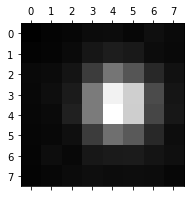

In [16]:
example_image = simulate_at_location(0.5, 0.9)[0][0]

f, ax = plt.subplots(1, 1, figsize=(5, 3))

plotting.plot_image(ax, example_image[0])

In [17]:
def get_var_params(image_encoder, images, background, n_sources, slen: int, wlen: int = None):
    # return full estimate of parameters in full image.
    # NOTE: slen*wlen is size of the image without border padding

    if wlen is None:
        wlen = slen
    assert isinstance(slen, int) and isinstance(wlen, int)
    # check image compatibility
    border1 = (images.shape[-2] - slen) / 2
    border2 = (images.shape[-1] - wlen) / 2
    assert border1 == border2, "border paddings on each dimension differ."
    assert slen % image_encoder.tile_slen == 0, "incompatible slen"
    assert wlen % image_encoder.tile_slen == 0, "incompatible wlen"
    assert border1 == image_encoder.border_padding, "incompatible border"

    # obtained estimates per tile, then on full image.
    log_images = subtract_bg_and_log_transform(images, background)
    log_image_ptiles = get_images_in_tiles(
        log_images, image_encoder.tile_slen, image_encoder.ptile_slen
    )
    var_params = image_encoder.encode(log_image_ptiles)
    var_params_flat = rearrange(var_params, "b nth ntw d -> (b nth ntw) d")
    
    pred = image_encoder.encode_for_n_sources(var_params_flat, n_sources.squeeze().unsqueeze(0))
    
    return(pred)

In [18]:
from einops import rearrange

In [19]:
delta_vec = np.linspace(0, 1, 101)
probs_onestar = np.zeros(len(delta_vec))
probs_onestar2 = np.zeros(len(delta_vec))

for i in range(len(delta_vec)): 
    images, batch = simulate_at_location(0.5, delta_vec[i])
    pred = get_var_params(sleep_net.image_encoder,
                      images,
                      dataset.background.view(1, 1, 1, 1).to(device), 
                      batch['n_sources'], 
                      slen = 2)
    
    
    pred2 = get_var_params(sleep_net2.image_encoder,
                      images,
                      dataset.background.view(1, 1, 1, 1).to(device), 
                      batch['n_sources'], 
                      slen = 2)
    
    probs_onestar[i] = pred['n_source_log_probs'].exp().mean(0)[1]
    probs_onestar2[i] = pred2['n_source_log_probs'].exp().mean(0)[1]

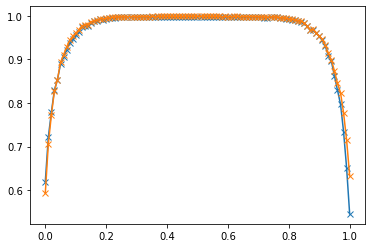

In [21]:
plt.plot(delta_vec, probs_onestar, '-x')
plt.plot(delta_vec, probs_onestar2, '-x')

In [18]:
delta_vec = np.linspace(0, 1, 101)
probs_onestar = np.zeros(len(delta_vec))

for i in range(len(delta_vec)): 
    images, batch = simulate_at_location(delta_vec[i], delta_vec[i])
    pred = get_var_params(sleep_net.image_encoder,
                      images,
                      dataset.background.view(1, 1, 1, 1).to(device), 
                      batch['n_sources'], 
                      slen = 2)
    
    probs_onestar[i] = pred['n_source_log_probs'].exp().mean(0)[1]

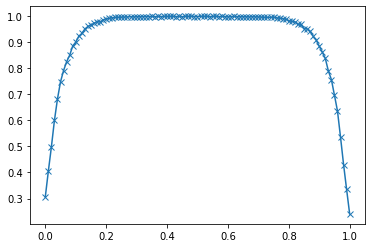

In [19]:
plt.plot(delta_vec, probs_onestar, '-x')